# Benchmarking

## 1. Prepare working environment

In [1]:
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

from scripts import Worker

In [2]:
!nvidia-smi

Thu May 18 01:34:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:C2:00.0 Off |                  Off |
|  0%   37C    P5    30W / 450W |      0MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Datasets and visulisation

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.data_info = self.get_img_info(data_dir)
        self.transforms = transforms

    def __getitem__(self, item):
        path_img, label = self.data_info.iloc[item][1:3]
        label = int(label)
        path_img = os.path.join(self.data_dir, path_img)
        image = Image.open(path_img).convert('RGB') # Gray scale is enough for logic interpretation
        # 使用定义好的transforms，对数据进行处理
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data_info)
    
    def get_img_info(self, data_dir):
        path_dir = os.path.join(data_dir, 'label.csv')
        return pd.read_csv(path_dir)

In [5]:
dataset_folder = "dataset01"

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = MyDataset(f"data/train/{dataset_folder}", transform)
testset = MyDataset(f"data/test/{dataset_folder}", transform)

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=8)

classes = (0, 1)

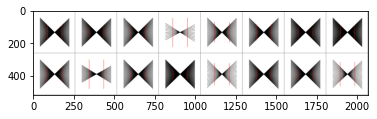

    0     1     1     1     1     1     0     0     0     0     0     0     0     0     0     0


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))


## 3. Model and training

In [7]:
timm.list_models('*tf_efficientnet_l2*', pretrained=True)

['tf_efficientnet_l2_ns', 'tf_efficientnet_l2_ns_475']

In [8]:
exp_name = f"{dataset_folder}_benchmarking"
model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
print(len(model_names))

10


In [9]:
for model_name in model_names:
    print(f"Log: {model_name}")
    model = timm.create_model(model_name, num_classes=2, pretrained=True)
    worker = Worker(exp_name, model_name, model, trainloader, testloader, epochs=1, lr=1e-4)
    worker.train()

Log: xception
state dict found: ./models/dataset01_benchmarking/xception.pt
Log: densenet201
state dict found: ./models/dataset01_benchmarking/densenet201.pt
Log: resnetv2_50
state dict found: ./models/dataset01_benchmarking/resnetv2_50.pt
Log: vgg16
state dict found: ./models/dataset01_benchmarking/vgg16.pt
Log: darknet53
state dict found: ./models/dataset01_benchmarking/darknet53.pt
Log: mobilenetv3_large_100
state dict found: ./models/dataset01_benchmarking/mobilenetv3_large_100.pt
Log: inception_resnet_v2
state dict found: ./models/dataset01_benchmarking/inception_resnet_v2.pt
Log: nasnetalarge
state dict found: ./models/dataset01_benchmarking/nasnetalarge.pt
Log: efficientnetv2_rw_m
state dict found: ./models/dataset01_benchmarking/efficientnetv2_rw_m.pt
Log: convnext_xlarge_384_in22ft1k


epoch,train_loss,valid_loss,accuracy,time
0,0.000175,0.000031,1.000000,02:09


epoch,train_loss,valid_loss,accuracy,time
0,0.000001,0.000001,1.000000,02:09


## 4. Metrics

In [10]:
from fastai.vision import *
from fastai.data.transforms import *

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=8)


exp_name = f"{dataset_folder}_benchmarking"
model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
benchmark_dict = {}

for model_name in model_names:
    print(model_name)
    
    if os.path.exists(f"models/{exp_name}/{model_name}_eval.csv"):
        benchmark_dict[model_name] = pd.read_csv(f"models/{exp_name}/{model_name}_eval.csv")
        continue
        
    benchmark_dict[model_name] = pd.DataFrame(columns = ["value", "type"])
    
    state_dict = torch.load(f"models/{exp_name}/{model_name}.pt")

    model = timm.create_model(model_name, num_classes=2).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # worker = Worker(exp_name, model_name, model, trainloader, testloader)
    # worker.eval()
    
    path_dir = os.path.join(f"data/test/{dataset_folder}", 'label.csv')
    info_df = pd.read_csv(path_dir)

    testiter = iter(testloader)

    for i in range(info_df.size-1):
        images, labels = next(testiter, (None, None))

        if images == None or labels == None:
            break

        if dataset_folder == "dataset01":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset02":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset03":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset04":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset05":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        images = images.to(device)
        
        # pred = worker.learner.model(images).argmax(1)[0]
        pred = model(images).argmax(1)[0]
        
        if (pred != label):
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FN'
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FP'
                
        else:
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TN'
                
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TP'
    
    for k, v in benchmark_dict.items():
        v.to_csv(f"models/{exp_name}/{k}_eval.csv")    

xception
densenet201
resnetv2_50
vgg16
darknet53
mobilenetv3_large_100
inception_resnet_v2
nasnetalarge
efficientnetv2_rw_m
convnext_xlarge_384_in22ft1k


In [11]:
for type_name in ['TP', 'TN', 'FP', 'FN']:
    print(type_name)
    for model_name in model_names:
        print(len(benchmark_dict[model_name][benchmark_dict[model_name]['type'] == type_name]))

TP
646
646
646
646
646
646
646
646
646
646
TN
1354
1354
1354
1354
1354
1354
1354
1354
1354
1354
FP
0
0
0
0
0
0
0
0
0
0
FN
0
0
0
0
0
0
0
0
0
0


In [12]:
for type_name in ['FN']:
    print(f"{type_name}_std")
    for model_name in model_names:
        print(benchmark_dict[model_name][benchmark_dict[model_name]['type'] == type_name]['value'].std())

FN_std
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


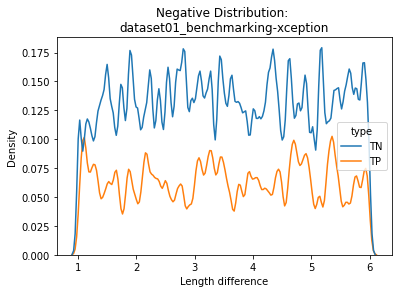

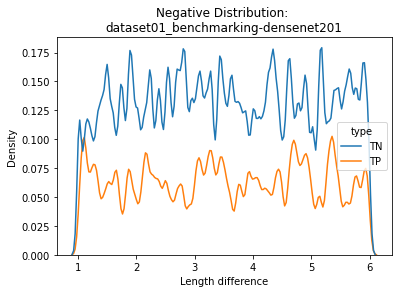

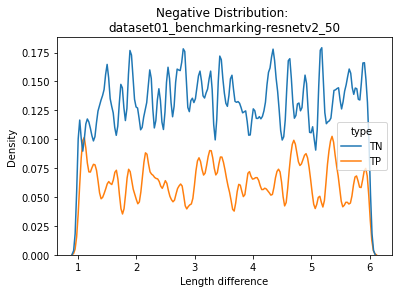

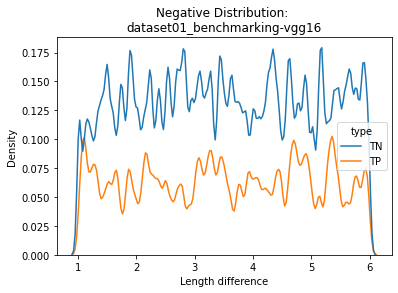

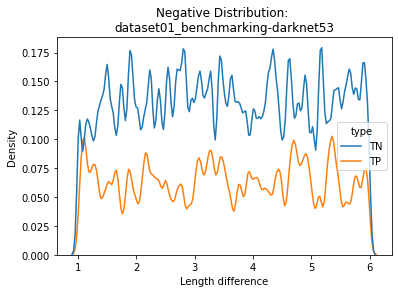

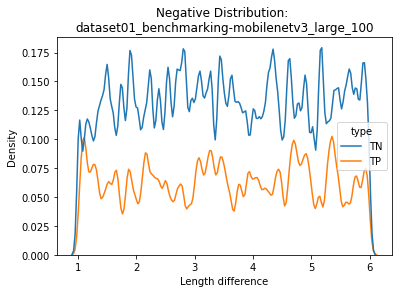

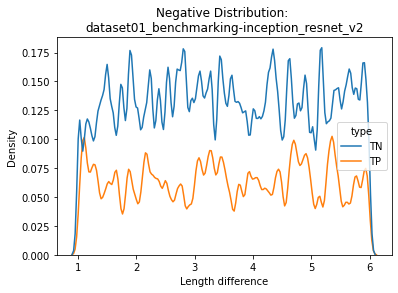

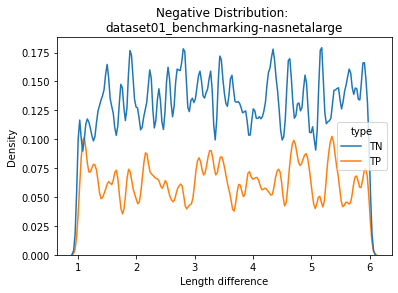

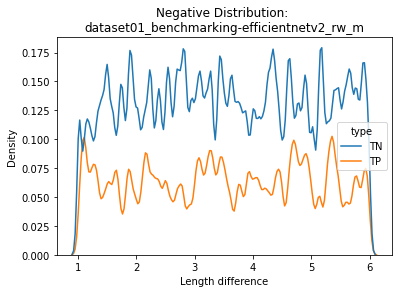

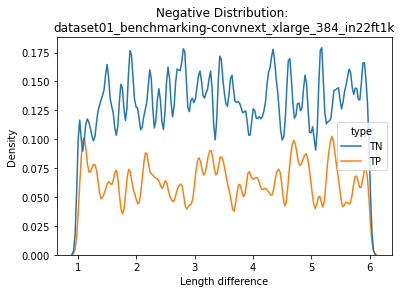

In [13]:
import seaborn as sns

for model_name in model_names:
    sns.kdeplot(data=benchmark_dict[model_name], x='value', hue='type', bw_adjust = 0.1)

    # plt.legend(['False Negative', 'True Negative'])
    plt.xlabel ("Length difference");
    # plt.ylabel ("");
    plt.title (f"Negative Distribution: \n{exp_name}-{model_name}");
    plt.show()

## 5. Cross evaluation

In [14]:
# from fastai.vision import *
# from fastai.data.transforms import *


# exp_name = f"model04x{dataset_folder}_benchmarking"
# model_exp_name = f"dataset04_benchmarking"
# model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
# benchmark_dict = {}

# os.mkdir(f"models/{exp_name}")

# for model_name in model_names:
#     print(model_name)
    
#     if os.path.exists(f"models/{exp_name}/{model_name}_eval.csv"):
#         benchmark_dict[model_name] = pd.read_csv(f"models/{exp_name}/{model_name}_eval.csv")
#         continue
        
#     benchmark_dict[model_name] = pd.DataFrame(columns = ["value", "type"])
    
#     state_dict = torch.load(f"models/{model_exp_name}/{model_name}.pt")

#     model = timm.create_model(model_name, num_classes=2).to(device)
#     model.load_state_dict(state_dict)
#     model.eval()

#     # worker = Worker(exp_name, model_name, model, trainloader, testloader)
#     # worker.eval()
    
#     path_dir = os.path.join(f"data/test/{dataset_folder}", 'label.csv')
#     info_df = pd.read_csv(path_dir)

#     testiter = iter(testloader)

#     for i in range(info_df.size-1):
#         images, labels = next(testiter, (None, None))

#         if images == None or labels == None:
#             break

#         if dataset_folder == "dataset01":
#             pass
#         elif dataset_folder == "dataset02":
#             label = info_df.iloc[i][2]
#             value = info_df.iloc[i][3]
#         elif dataset_folder == "dataset04":
#             label = info_df.iloc[i][2]
#             value = info_df.iloc[i][3] - info_df.iloc[i][4]
#         images = images.to(device)
        
#         # pred = worker.learner.model(images).argmax(1)[0]
#         pred = model(images).argmax(1)[0]
        
#         if (pred != label):
#             if (label == 0):
#                 benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FN'
#             else:
#                 benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FP'
                
#         else:
#             if (label == 0):
#                 benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TN'
                
#             else:
#                 benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TP'
    
#     for k, v in benchmark_dict.items():
#         v.to_csv(f"models/{exp_name}/{k}_eval.csv")    

In [15]:
# import seaborn as sns

# for model_name in model_names:
#     sns.kdeplot(data=benchmark_dict[model_name], x='value', hue='type', multiple='fill', bw_adjust = 0.5)

#     # plt.legend(['False Negative', 'True Negative'])
#     plt.xlabel ("Length difference");
#     # plt.ylabel ("");
#     plt.title (f"Negative Distribution: \n{exp_name}-{model_name}");
#     plt.show()